In [53]:
from glob import glob
from PIL import Image, ImageFilter
import cv2
from skimage import io, util
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import random
import numpy as np
import pytesseract
from pdf2image import convert_from_path
import imgaug as ia
from imgaug import augmenters as iaa
import unidecode

## PDF to JPG
Para cada processo, aplica-se o pdf2image e cria-se novas imagens, uma para cada página do pdf

A partir das imagens geradas, cria-se uma pipeline para gerar imagens ruins

In [37]:
pages = convert_from_path('processo.pdf', dpi=200, output_folder='.', fmt='jpg', size=(800, None), grayscale=True)

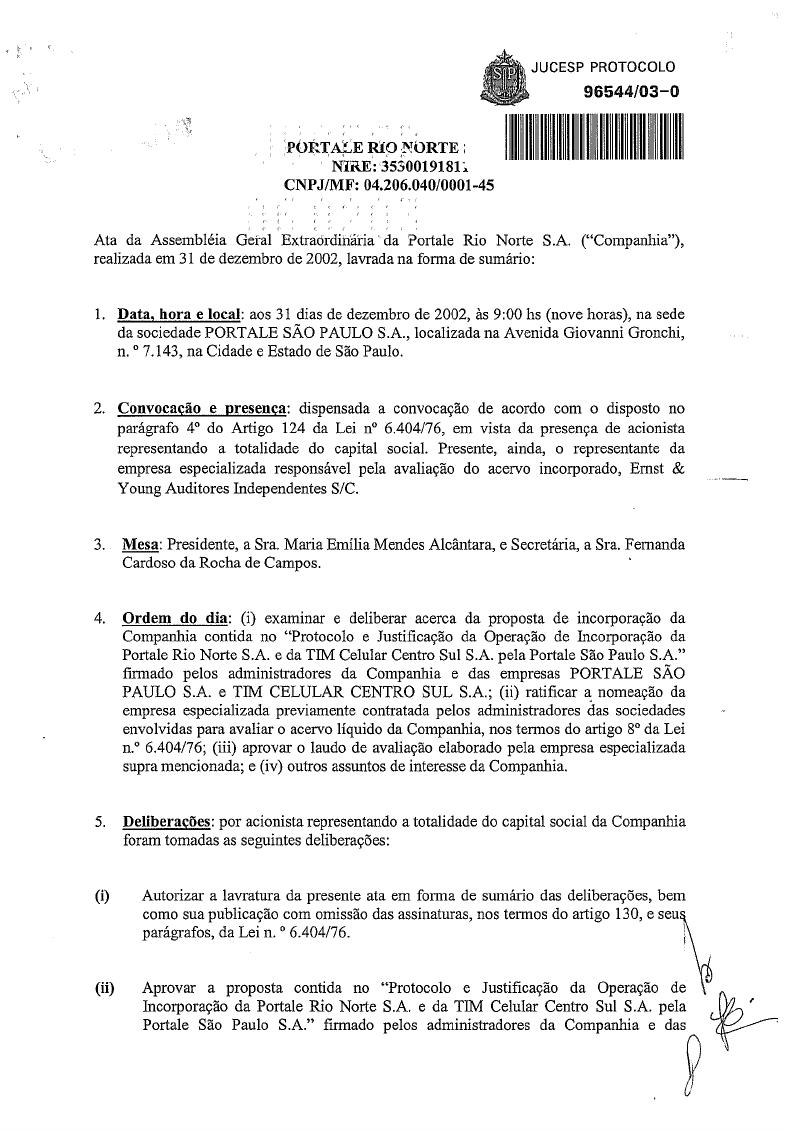

In [38]:
paths = glob('*.jpg')
random_path = random.choice(paths)

# getting image
image = cv2.imread(random_path)
height, width, channels = image.shape
Image.fromarray(image)

In [39]:
def random_overlay(shape, color=(55, 55, 55)):
    import random
    import cv2
    # get image shape
    height, width, channels = shape

    # create blank white image
    overlay = 255 * np.ones(shape=[height, width, channels], dtype=np.uint8)
    
    # randomize crappy shape and position
    ## 0 - rectangle
    ## 1 - line
    ## 2 - circle
    for i in range(3):
        # get randomic shape position
        x1, y1 = [random.choice(range(0, width)), random.choice(range(0, height))]
        x2, y2 = [random.choice(range(0, width)), random.choice(range(0, height))]
        
        # select random shape
        shape_range = range(0, 2)
        randomic_shape = random.choice(shape_range)
        if randomic_shape == 0:
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)
        elif randomic_shape == 1:
            cv2.line(overlay, (x1, y1), (x2, y2), color, 80)        
        else:
            cv2.circle(overlay, (x1, y1), (x2, y2), color, -1)
    overlay = cv2.blur(overlay, (100, 100))
    return overlay

overlay = random_overlay(image.shape)

In [40]:
alpha = 0.6
new_image = cv2.addWeighted(image, alpha, overlay, 1 - alpha, 0)

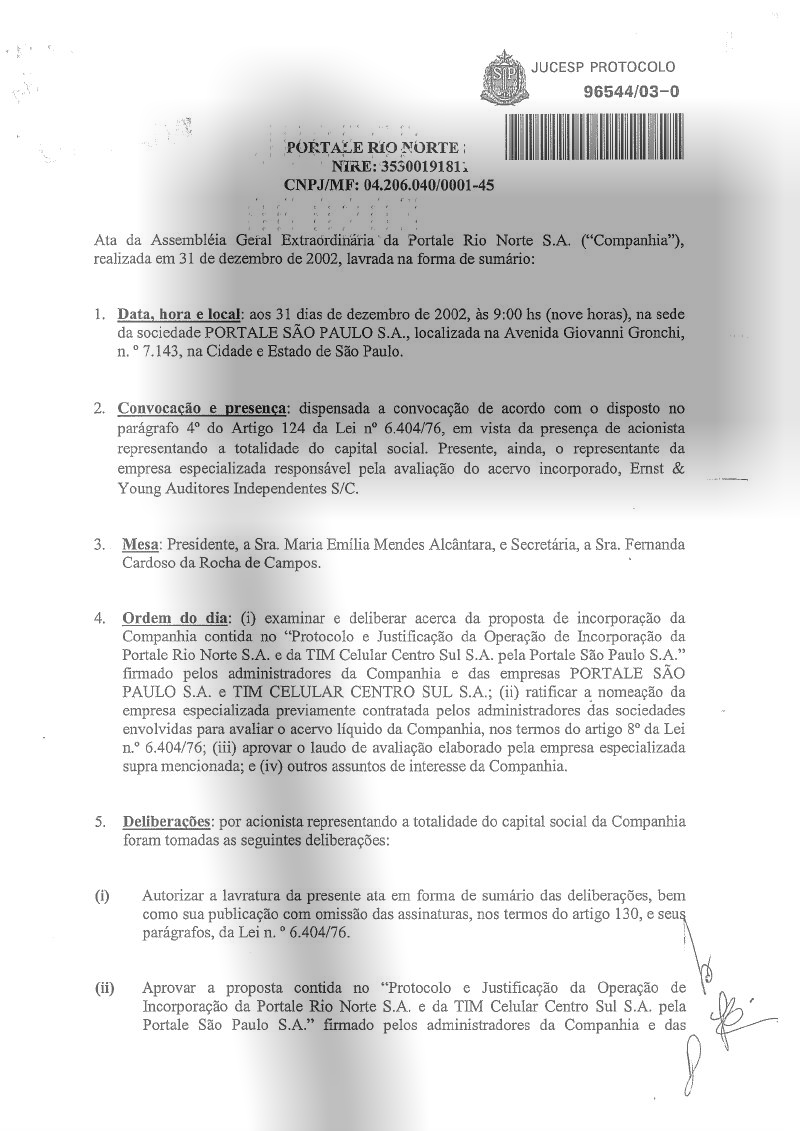

In [41]:
Image.fromarray(new_image)

In [42]:
# res = pytesseract.image_to_string(image)
# print(len(res.split('\n')))
# res.split('\n')

In [43]:
# res = pytesseract.image_to_string(new_image)
# print(len(res.split('\n')))
# res.split('\n')

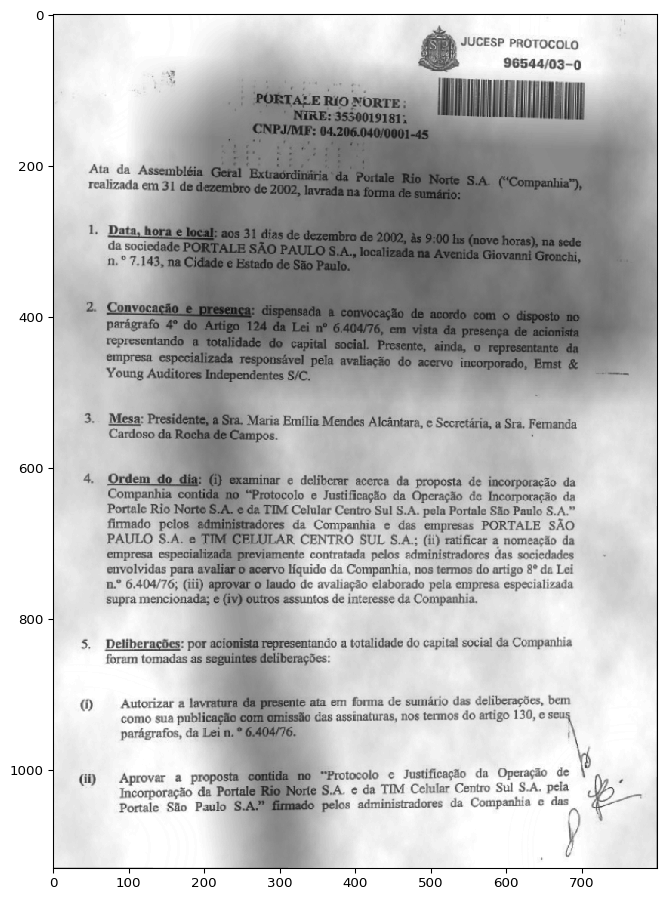

In [44]:
seq = iaa.Sequential([
    iaa.PerspectiveTransform(random_state=1, scale=0.05),
    iaa.Fog(),
    iaa.Affine(rotate=0.01),
    iaa.GammaContrast(3)
])

c = seq.augment_image(new_image)
ia.imshow(c)

In [45]:
def image_ocr(image_path, output_txt_file_name):
    image_text = pytesseract.image_to_string(image_path, lang='por+eng', config='--psm 1')
    with open(output_txt_file_name, 'w+', encoding='utf-8') as f:
        f.write(image_text)

In [121]:
text = pytesseract.image_to_string(image, lang='por+eng', config='--psm 1').replace('\n', ' ')
good_ocr = unidecode.unidecode(text)
good_ocr

'JUCESP PROTOCOLO 96544/03-0 PORTAL HID NORTE: EA) Ni  IRE: 35500191813, CNPJ/MF: 04.206.040/0001-45  Ata da Assembleia Geral Extraordinaria da Portale Rio Norte S.A. ("Companhia"), realizada em 31 de dezembro de 2002, lavrada na forma de sumario:  1, Data, hora e local: aos 31 dias de dezembro de 2002, as 9:00 hs (nove horas), na sede da sociedade PORTALE SAO PAULO S.A., localizada na Avenida Giovanni Gronchi, n.o 7.143, na Cidade e Estado de Sao Paulo.  2. Convocacao e presenca: dispensada a convocacao de acordo com o disposto no paragrafo 4o do Artigo 124 da Lei no 6.404/76, em vista da presenca de acionista representando a totalidade do capital social. Presente, ainda, o representante da empresa especializada responsavel pela avaliacao do acervo incorporado, Emst & Young Auditores Independentes S/C.  3. Mesa: Presidente, a Sra. Maria Emilia Mendes Alcantara, e Scoretaria, a Sra. Femanda Cardoso da Rocha de Campos.     4, Ordem do dia: (i) examinar e deliberar acerca da proposta de 

In [122]:
text = pytesseract.image_to_string(c, lang='por+eng', config='--psm 1').replace('\n', ' ')
bad_ocr = unidecode.unidecode(text)
bad_ocr

'JUCESP PROTOCOLO 96544/03-0       4  da Companhia e das empresas PORTALE SAO CENTRO SUL S.A.; (ii) ratificar a nomeacao da mente contratada pelos administradores das sociedades o liquido da Companhia, nos termos do artigo 8o da Lei de avaliacao elaborado pela empresa especializada  fos assuntos de interesse da Companhia.  do a totalidade do capital social da Companhia                     cata forma de sumario das deliberacoes, bem  @ t como sua publicaca o das assinaturas, nos termos do artigo 130, e s paragrafos, da Lei  GD Aprovar a                Incorporacao da  Portale Sao Paulo S  "Protocolo e Justificacao da Operacao de J S.A. e da TIM Celular Centro Sul S.A. pela | o pelos administradores da Companhia e das'

In [70]:
from collections import Counter
import re

In [104]:
def format_word(string):
    new_string = re.sub('[\d\W]+', '', string, flags=re.M)
    if len(new_string) == 0:
        return None
    return new_string.lower()

In [118]:
words_array = map(format_word, good_ocr.split())
counter = Counter(words_array)
del counter[None]
good_ocr_size = len(counter.most_common())

In [119]:
bad_words_array = map(format_word, bad_ocr.split())
result = Counter(bad_words_array)
del result[None]
bad_ocr_size = len(result.most_common())

In [123]:
bad_ocr_size / good_ocr_size

0.40397350993377484